# Pricer Option basket
---


#### Libraries set up 
---

In [64]:
import numpy as np
import scipy.stats as sps
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()
from numpy.random import default_rng, SeedSequence

sq = SeedSequence()
rng = default_rng(sq)


#### Context

We consider $d \ge 2$ financial assets whose distribution at time  $T > 0$ is modeled by a log-normal distribution, that is,
$$
    \forall i \in \{1,\dots,d\}, \quad
    S^i_T = S^i_0 \exp\Bigl( \bigl(r-\frac{\sigma_i^2}{2}\bigr) T + \sigma_i \sqrt{T} \tilde G_i \Bigr)
$$
where the vector $(\tilde G_1,\dots, \tilde G_d)$ is Gaussian with mean zero and covariance matrix $\Sigma$ and the constants $r > 0$, $\sigma_i > 0$ . IThese are financial assets $(S^i_t)_{t \in [0,T]}$, $1 \le i \le d$, modeled by a multidimensional Black-Scholes process. We introduce the lower triangular matrix $L$ obtained by the Cholesky decomposition of the matrix $\Sigma = L L^\top$. 

Using this matrix $L$, we define the function $\Phi:\mathbf{R}^d \to \mathbf{R}^d$ such that
$$
    (S^1_T, \dots, S^d_T) = \Phi(G_1, \dots, G_d) \quad \text{ou encore} \quad S^i_T = \Phi_i(G_1, \dots, G_d)
$$
où $(G_1, \dots, G_d) \sim \mathcal{N}(0, I_d)$ (the previous equality is to be considered in distribution).





In [68]:
d = 40
T = 1
r = 0.1
S0 = np.full(d, 100)
#sigma = np.arange(1,d+1)/(2*d)
sigma = np.full(d, 0.3)
rho = 0.3
correl = np.full((d,d), rho) + (1-rho)*np.eye(d) # ou np.diag(np.full(d, 1-rho))
K = 100

In [69]:
params = {
    "S0": S0[:, np.newaxis],
    "sigma": sigma[:, np.newaxis],
    "mu": r-0.5*sigma[:, np.newaxis]**2,
    "sq_correl": np.linalg.cholesky(correl),  # c'est la matrice L tq L L^T = \Sigma
    "maturity": T,
    "strike": K
}

In [70]:
def phi(indep_Gn, S0, mu, sigma, sq_correl, maturity, strike):
    ST = S0 * np.exp(mu * maturity + sigma * np.sqrt(maturity) * sq_correl @ indep_Gn)
    return np.maximum(np.mean(ST, axis=0)-strike, 0)

## Approximation Monte Carlo
---

We are interested in the price of a European option (also known as a European derivative) on the basket of these $d$ financial assets, meaning we want to calculate 
$$
    \mathbf{E} \bigl[ X \bigr] %\quad \text{avec} \quad g(x) = (x-K)_+ \quad \text{ou} \quad g(x) = (K-x)_+ 
    \quad \text{avec} \quad 
    X = \biggl(\frac{1}{d} \sum_{i=1}^d S^i_T  - K\biggr)_+
$$

In [71]:
def monte_carlo(sample, proba = 0.95):
    mean = np.mean(sample)
    var = np.var(sample, ddof=1)
    alpha = 1 - proba 
    quantile = sps.norm.ppf(1 - alpha/2)  # fonction quantile 
    ci_size = quantile * np.sqrt(var / sample.size)
    return (mean, var, mean - ci_size, mean + ci_size)

In [72]:
n = int(1e5)
Gn = rng.standard_normal((d, n)) # ici on a n scénarios possibles 

In [73]:
Gn

array([[ 0.86510093,  0.28075451,  0.01314501, ..., -0.96115266,
         1.1061931 , -0.21609412],
       [ 0.49670362, -0.86646224,  0.44129649, ..., -0.27137062,
        -0.00934686, -0.22803408],
       [ 0.35659144, -0.16071928, -0.84159715, ..., -1.9608045 ,
         0.92856353,  0.0961268 ],
       ...,
       [-0.04376139,  0.73081677,  0.99916756, ..., -0.458836  ,
         1.03244154,  0.31482381],
       [-0.30260124,  0.15696493, -0.63855625, ...,  0.72733913,
        -0.91415998,  0.52289309],
       [-2.84031078, -0.7116379 , -0.89703459, ...,  0.06952089,
         0.68868552,  0.01630484]])

In [74]:
sample = phi(Gn,**params)
monte_carlo(sample)

(13.478188082685477,
 231.64957991540598,
 13.383855038524054,
 13.572521126846901)

We want to calculate the price for different values of the 'strike', so we remove the 'strike' field from the param dictionary and will vary this parameter.

In [75]:
Ks = [80, 90, 100, 110, 120]
del params["strike"]

In [76]:
result = [monte_carlo(phi(Gn, strike=K, **params)) for K in Ks]
result_df = pd.DataFrame(result, 
                         columns=['Mean', 'Var', 'Lower', 'Upper'], index=Ks)
result_df

,Mean,Var,Lower,Upper
80,30.595047,340.459677,30.480685,30.709409
90,21.352913,302.697215,21.245080,21.460746
100,13.478188,231.649580,13.383855,13.572521
110,7.622718,147.822155,7.547362,7.698074
120,3.872937,79.252758,3.817760,3.928114


We can see that our variances are quite big suggesting that we can not feel so confident in the estimate price outputs by the Monte Carlo method. Let now investigate Variance reduction methods though.

We will try two methods and see which one leads to a consistent reduction of our Variance.

## Variance Methods reduction

## 1. Antithetic Variables

Following the bsame model as before, we code a function `phi_antith` that evaluates
$$
    \frac{1}{2} \bigl( \Phi(G_1, \dots, G_d) + \Phi(-G_1, \dots, -G_d) \bigr)
$$
and will then be used to implement the Monte Carlo method with variance reduction using antithetic variables.


In [77]:
def phi_antith(indep_Gn, **params):
    return 0.5 * (phi(indep_Gn, **params) + phi(-indep_Gn, **params))

In [78]:
sample = phi_antith(Gn, strike=100, **params)
monte_carlo(sample)

(13.546442505292996,
 36.009419012465216,
 13.509249938791946,
 13.583635071794046)

In [79]:
Ks = [80, 90, 100, 110, 120]
result_antith = [monte_carlo(phi_antith(Gn, strike=K, **params)) for K in Ks]
result_antith_df = pd.DataFrame(result_antith, 
                                columns=['Mean', 'Var', 'Lower', 'Upper'], index=Ks)
result_antith_df

,Mean,Var,Lower,Upper
80,30.689389,9.317532,30.670470,30.708308
90,21.434462,19.222024,21.407289,21.461636
100,13.546443,36.009419,13.509250,13.583635
110,7.680726,45.395838,7.638967,7.722486
120,3.919365,32.656809,3.883946,3.954783


We see our our variances are drastically reduced by using the variable antithetic method for variance reduction.
Following codes show the ratio with the simple Monte Carlo method

In [80]:
ratio_var = pd.DataFrame({
    "method": "Antithetic",
    "strike": Ks, 
    "ratio": result_df['Var'] / result_antith_df['Var'], 
})
ratio_var

,method,strike,ratio
80,Antithetic,80,36.539685
90,Antithetic,90,15.747416
100,Antithetic,100,6.433027
110,Antithetic,110,3.256293
120,Antithetic,120,2.426837


<Axes: xlabel='strike', ylabel='ratio'>

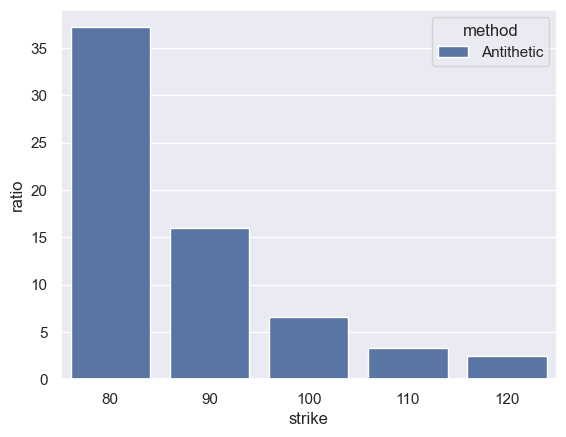

In [22]:
sns.barplot(data=ratio_var, x="strike", y="ratio", hue="method")

We observe that the ratio decreases with the strike of the option.

## 2. Control Variates

Recall that in a one-dimensional Black-Scholes model, the price of a call option is given by a closed-form formula. For a basket option(in dimension $d \ge 2$), the price is approximated using Monte Carlo, but one can use approximations to find a unidimensional product close to the basket product. These approximations serve as control variates: **Instead of adding an error, they reduce variance**... 


In [81]:
def d1(spot, t, r, sigma, strike):
    return (np.log(spot / strike) + t * (r + 0.5*sigma**2)) / (sigma * np.sqrt(t))

In [82]:
def d2(spot, t, r, sigma, strike):
    return d1(spot, t, r, sigma, strike) - sigma * np.sqrt(t)

In [83]:
def price_call_BS(spot, t, r, sigma, strike):
    d1_ = d1(spot, t, r, sigma, strike)
    d2_ = d2(spot, t, r, sigma, strike)
    return spot * sps.norm.cdf(d1_) - strike * np.exp(-r * t) * sps.norm.cdf(d2_)

Recall that, by setting $\mu_i = r - \frac{1}{2}\sigma_i^2$,
$$
    X = \biggl(\frac{1}{d} \sum_{i=1}^d S^i_0 e^{\mu_i T + \sigma_i \sqrt{T} \tilde G_i}  - K\biggr)_+
$$
and by introducing $a^i_0 = \frac{S^i_0}{\sum_{j=1}^d S^j_0}$ (t.q. $\sum a^i_0 = 1$) et $\bar S_0 = \frac{1}{d} \sum_{i=1}^d S^i_0$ on a 
$$
    X = \biggl(\bar S_0 \sum_{i=1}^d a^i_0 e^{\mu_i T + \sigma_i \sqrt{T} \tilde G_i}  - K\biggr)_+.
$$
The proposed control variate is obtained by exchanging the logarith of the exponential and the weighted average by the weights $\big(a^i_0\big)_{i=1,\dots,d}$:
$$
    Y = \bigl(\bar S_0 e^Z  - K\bigr)_+
    \quad \text{avec} \quad 
    Z = \sum_{i=1}^d a^i_0 \big(\mu_i T + \sigma_i \sqrt{T} \tilde G_i\big) 
$$
The random variable  $Z$ follows a Gaussian distribution $Z \sim \mathcal{N}(m T, s^2 T)$ with
$$
    m = \sum_{i=1}^d a^i_0 \mu_i
    \quad \text{et} \quad
    s^2 = \sum_{i=1}^d \Big( \sum_{j=1}^d a^i_0 \sigma_i L_{ij} \Big)^2. 
$$
Thus, the bexpectation of the control variable  $Y$ is known from the Black scholes formula, as it corresponds to the price of a call option with strike $K$ on a one-dimensional Black_Choles asset, with an initial value $\bar S_0$, interest rate $\rho = m+\frac{1}{2} s^2$ and volatility $s$ (up to a discount factors... be mindful of this). Therefore, we have 
$$
    e^{-\rho T} \mathbf{E} \big[ Y \big] = P_{\text{BS}}\big(\bar S_0, \rho, s, T, K\big) 
$$

First, we check the formulas: the true expectation of $Y$ calculated using the closed-form formula must be within the confidence interval of a Monte Carlo estimator based on a large sample $(Y_1,\dots,Y_n)$.

In [84]:
barS0 = params["S0"].mean()
a = params["S0"] / params["S0"].sum()
m = (a * params["mu"]).sum()
s2 = (((a * params["sigma"]).T @ params["sq_correl"])**2).sum()
rho = m + 0.5*s2

In [85]:
# calcul par formule fermée
Y_mean = np.exp(rho*T) * price_call_BS(barS0, T, rho, np.sqrt(s2), strike=K)
print("True value:", Y_mean)

True value: 11.140982930779245


In [86]:
# calcul par Monte Carlo
Z = np.sum(a * (m*T + params["sigma"]*np.sqrt(T)*params["sq_correl"] @ Gn), axis = 0)
Y = np.maximum(S0.mean() * np.exp(Z) - K, 0) 
monte_carlo(Y)

(11.064572595832683, 192.73977223726078, 10.97852598647709, 11.150619205188276)

We combine everything into a function $\Psi$ dwhich is called similarly to $\Phi$ and returns realizations of $Y - \mathbf{E}[Y]$.  It is often more convenient to use centered control variates..

In [87]:
def psi(indep_Gn, S0, mu, sigma, sq_correl, maturity, strike):
    weight = S0 / S0.sum()
    m = (weight * mu).sum()
    s2 = (((weight * sigma).T @ sq_correl)**2).sum()
    rho = m + 0.5*s2

    Z = np.sum(weight * (m*maturity + sigma*np.sqrt(maturity)*sq_correl @ indep_Gn), axis = 0)
    Y = np.maximum(S0.mean() * np.exp(Z) - strike, 0) 
    Y_mean = np.exp(rho*T) * price_call_BS(S0.mean(), maturity, rho, np.sqrt(s2), strike=strike) 
    return Y - Y_mean

In [88]:
# exemple d'un appel de Monte Carlo avec variable de contôle $Y = \Psi(G_1,\dots, G_n)$
sample = phi(Gn, **params, strike=100) - psi(Gn, **params, strike=100)
monte_carlo(sample)

(13.55459841763204, 3.4775127449648164, 13.543040423857937, 13.566156411406142)

In [32]:
Ks = [80, 90, 100, 110, 120]
sample = lambda K: phi(Gn, strike=K, **params) - psi(Gn, strike=K, **params) 
result_cv = [monte_carlo(sample(K)) for K in Ks]
result_cv_df = pd.DataFrame(result_cv, 
                            columns=['Mean', 'Var', 'Lower', 'Upper'], index=Ks)
result_cv_df

,Mean,Var,Lower,Upper
80,30.684226,1.313826,30.677122,30.691330
90,21.429241,2.254147,21.419935,21.438546
100,13.551422,3.458661,13.539895,13.562949
110,7.691453,3.928923,7.679168,7.703739
120,3.928298,3.301745,3.917036,3.939561


In [89]:
def mk_ratio_df(method, ratio): 
    return pd.DataFrame({
        "method": method,
        "strike": Ks, 
        "ratio": ratio, 
    }, index=None)

In [90]:
ratio_var = pd.concat([
    mk_ratio_df("Antithetic", result_df['Var'] / result_antith_df['Var']),
    mk_ratio_df("Control Variate", result_df['Var'] / result_cv_df['Var']),
], ignore_index=True)
ratio_var

,method,strike,ratio
0,Antithetic,80,36.539685
1,Antithetic,90,15.747416
2,Antithetic,100,6.433027
3,Antithetic,110,3.256293
4,Antithetic,120,2.426837
5,Control Variate,80,259.136109
6,Control Variate,90,134.284617
7,Control Variate,100,66.976657
8,Control Variate,110,37.624088
9,Control Variate,120,24.003294


<Axes: xlabel='strike', ylabel='ratio'>

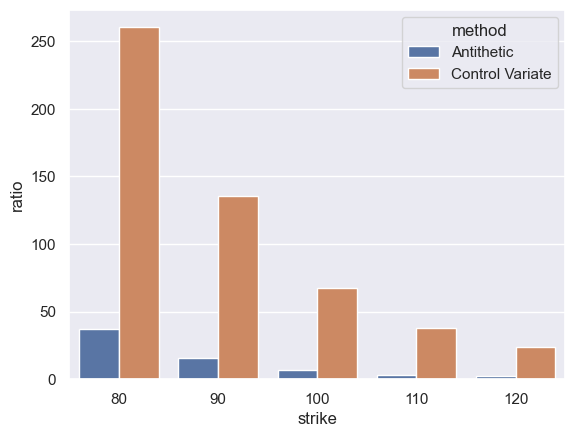

In [35]:
sns.barplot(data=ratio_var, x="strike", y="ratio", hue="method")

We see that the control variate method performs better than the antithetic variates method and also that the ratio, as with the antithetic variates, decreases with the strike \( K \).

### Optimal Control Variate


if $Y$ is a control variate

In [91]:
Ks = [80, 90, 100, 110, 120]

def sample1(K):
    Xn = phi(Gn, **params, strike=K)
    Yn = psi(Gn, **params, strike=K)
    lambd = (Xn*Yn).mean() / (Yn*Yn).mean()
    return Xn - lambd * Yn
result_cv2 = [monte_carlo(sample1(K)) for K in Ks]
result_cv2_df = pd.DataFrame(result_cv2, 
                            columns=['Mean', 'Var', 'Lower', 'Upper'], index=Ks)
result_cv2_df

,Mean,Var,Lower,Upper
80,30.689626,0.842438,30.683938,30.695315
90,21.439225,1.306109,21.432142,21.446309
100,13.561211,1.854661,13.552770,13.569652
110,7.701609,2.002490,7.692839,7.710380
120,3.924415,1.622090,3.916521,3.932308


In [92]:
ratio_var = pd.concat([
    mk_ratio_df("Antithetic", result_df['Var'] / result_antith_df['Var']),
    mk_ratio_df("Control Variate", result_df['Var'] / result_cv_df['Var']),
    mk_ratio_df("Control Variate adapt", result_df['Var'] / result_cv2_df['Var']),
], ignore_index=True)
ratio_var

,method,strike,ratio
0,Antithetic,80,36.539685
1,Antithetic,90,15.747416
2,Antithetic,100,6.433027
3,Antithetic,110,3.256293
4,Antithetic,120,2.426837
5,Control Variate,80,259.136109
6,Control Variate,90,134.284617
7,Control Variate,100,66.976657
8,Control Variate,110,37.624088
9,Control Variate,120,24.003294


<Axes: xlabel='strike', ylabel='ratio'>

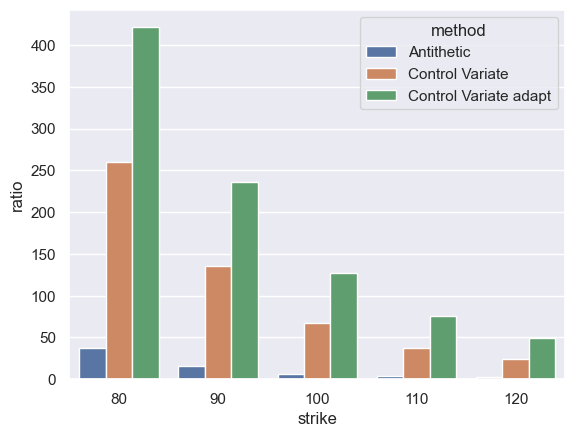

In [38]:
sns.barplot(data=ratio_var, x="strike", y="ratio", hue="method")

## Combination of the Two Previous Methods

In [93]:
Ks = [80, 90, 100, 110, 120]
def sample2(K):
    Xn = phi(Gn, **params, strike=K)
    Yn = psi(Gn, **params, strike=K)
    lambd = (Xn*Yn).mean() / (Yn*Yn).mean()
    return 0.5*((Xn - lambd * Yn) \
                + (phi(-Gn, strike=K, **params) - lambd * psi(-Gn, strike=K, **params)))
result_acv = [monte_carlo(sample2(K)) for K in Ks]
result_acv_df = pd.DataFrame(result_acv, 
                            columns=['Mean', 'Var', 'Lower', 'Upper'], index=Ks)
result_acv_df

,Mean,Var,Lower,Upper
80,30.691963,0.675322,30.686869,30.697056
90,21.439981,0.991517,21.433810,21.446153
100,13.562552,1.251393,13.555618,13.569485
110,7.698641,0.542805,7.694075,7.703208
120,3.926563,0.663196,3.921515,3.931610


<Axes: xlabel='strike', ylabel='ratio'>

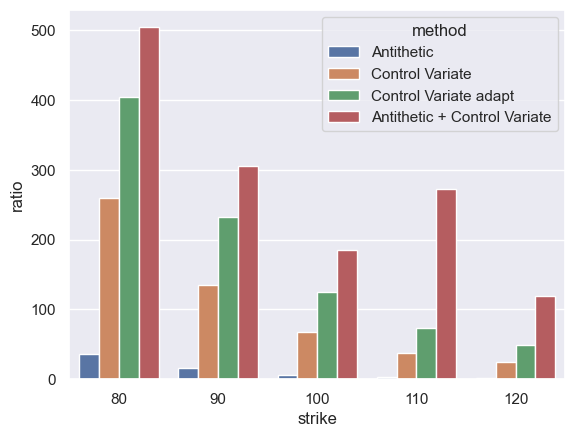

In [94]:
ratio_var = pd.concat([
    mk_ratio_df("Antithetic", result_df['Var'] / result_antith_df['Var']),
    mk_ratio_df("Control Variate", result_df['Var'] / result_cv_df['Var']),
    mk_ratio_df("Control Variate adapt", result_df['Var'] / result_cv2_df['Var']),
    mk_ratio_df("Antithetic + Control Variate", result_df['Var'] / result_acv_df['Var']),
], ignore_index=True)
sns.barplot(data=ratio_var, x="strike", y="ratio", hue="method")

The result is much better than the previous methods in terms of the ratio, and it also appears to be independent of the strike value.

## Sensitivities to Parameters

As all our code works (or seems to work) for a given set of parameters, let's now begin a proper numerical study by varying the parameters.

For example, we will rerun the notebook with a different correlation.
- What are the variance ratios with $\rho = 0$ ? $\rho = 0.5$ ? How do we interpret these results?
- Similarly, what if the volatilities $\sigma_i$ are not all identical ?
- Dependence on the dimension $d$ ?

To address these questions, we'll take the code from the notebook and implement a function that returns a `DataFrame` containing all the results for each parameter value.

In [164]:
# Function to run the simulation with different parameters
def run_simulation(d, rho, sigma_values, T=1, r=0.1, S0_value=100, K=100, n=int(1e5)):
    S0 = np.full(d, S0_value)
    sigma = sigma_values if isinstance(sigma_values, np.ndarray) else np.full(d, sigma_values)
    correl = np.full((d,d), rho) + (1-rho)*np.eye(d)
    params = {
        "S0": S0[:, np.newaxis],
        "sigma": sigma[:, np.newaxis],
        "mu": r - 0.5 * sigma[:, np.newaxis]**2,
        "sq_correl": np.linalg.cholesky(correl),
        "maturity": T,
        "strike": K
    }
    
    # Generate normal random variables
    Gn = rng.standard_normal((d, n))
    
    # Monte Carlo sampling
    sample = phi(Gn, **params)
    result = monte_carlo(sample)
    
    # Antithetic Sampling
    sample_antith = phi_antith(Gn, **params)
    result_antith = monte_carlo(sample_antith)
    
    # Control Variate
    sample_cv = phi(Gn, **params) - psi(Gn, **params)
    result_cv = monte_carlo(sample_cv)
    
    # optimal control variate
    sample_ocv= sample1(K)
    result_ocv=  monte_carlo(sample_ocv)
    
    # Combination of av et cv
    sample_combi= sample2(K)
    result_combi= monte_carlo(sample_combi)
    
    return result, result_antith, result_cv, result_ocv, result_combi

### 1. Parameter $\rho $

In [166]:
#N = 500000
rho_values = np.linspace(0.,1.,10,endpoint=False)
#print(rho_values)
d_values = [10]
sigma_values = [0.2]


In [167]:
def collect_results(d_values, rho_values, sigma_values):
    results = []
    
    # Étudier la dépendance par rapport à rho
    for d in d_values:
        for sigma in sigma_values:
            for rho in rho_values:
                res, res_antith, res_cv,res_ocv, res_combi = run_simulation(d, rho, sigma)
                #print(res)
                #print(res_antith)
                #print(res_combi)
                
                # Calculer les ratios de variance
                mc_var = res[1]
                antith_var = res_antith[1]
                cv_var = res_cv[1]
                ocv_var= res_ocv[1]
                combi_var=res_combi[1]
                
                ratio_antith =  mc_var/antith_var  if antith_var != 0 else None
                ratio_cv =  mc_var/cv_var if cv_var != 0 else None
                ratio_ocv = mc_var/ocv_var   if ocv_var != 0 else None
                ratio_combi = mc_var/combi_var if combi_var != 0 else None
                
                
                results.append({
                    "rho": rho,
                    "Ratio_Antithetic": ratio_antith,
                    "Ratio_CV": ratio_cv,
                    "Ratio_OCV": ratio_ocv,
                    "Ratio_Combi": ratio_combi
                    
                })
                
    return pd.DataFrame(results)

In [168]:
df_results = collect_results(d_values=d_values, rho_values=rho_values, sigma_values=sigma_values)

# Display results
df_results


,rho,Ratio_Antithetic,Ratio_CV,Ratio_OCV,Ratio_Combi
0,0.0,28.674045,41.094212,24.469720,36.266001
1,0.1,18.752577,73.055267,41.841580,62.012430
2,0.2,12.954572,114.186839,57.182334,84.748604
3,0.3,10.386847,178.162365,72.356731,107.238223
4,0.4,8.767998,277.298086,86.077289,127.573142
5,0.5,7.763866,444.632066,99.223803,147.057283
6,0.6,6.969526,764.740859,113.388095,168.049850
7,0.7,6.485532,1517.941051,129.774644,192.335973
8,0.8,6.061631,3648.015361,142.630624,211.389521
9,0.9,5.700397,15649.770939,156.078859,231.320836


As all the ratio don't have the same scale . Let's plot different graphs to see the evolution of each ratio up to $\rho$

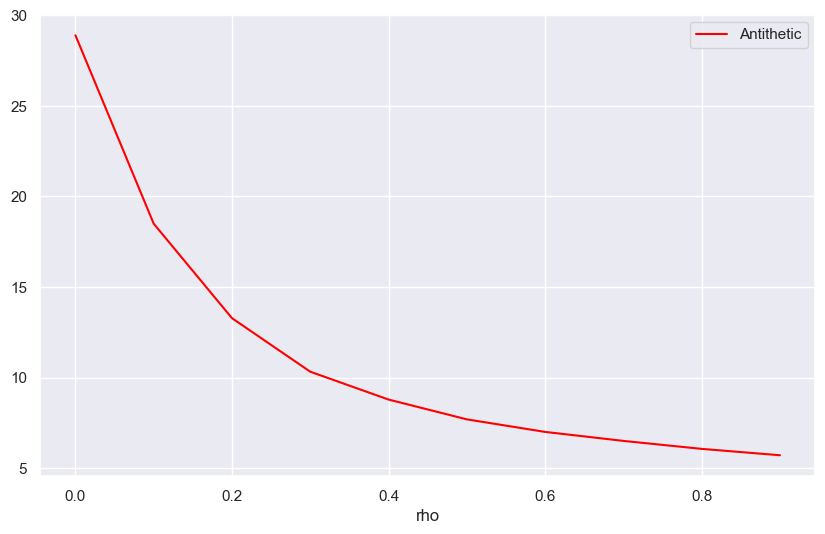

In [143]:
fig = plt.figure(figsize=(10,6))

plt.plot(df_results['rho'], df_results['Ratio_Antithetic'], color='Red', label='Antithetic')
plt.xlabel('rho')
 #plt.plot(df_results['rho'],df_results['Ratio_Antithetic'])
#plt.xlabel('Time step h')
plt.legend()
plt.show()

The more the correlation between assets are important the less the Antithetic variates performs

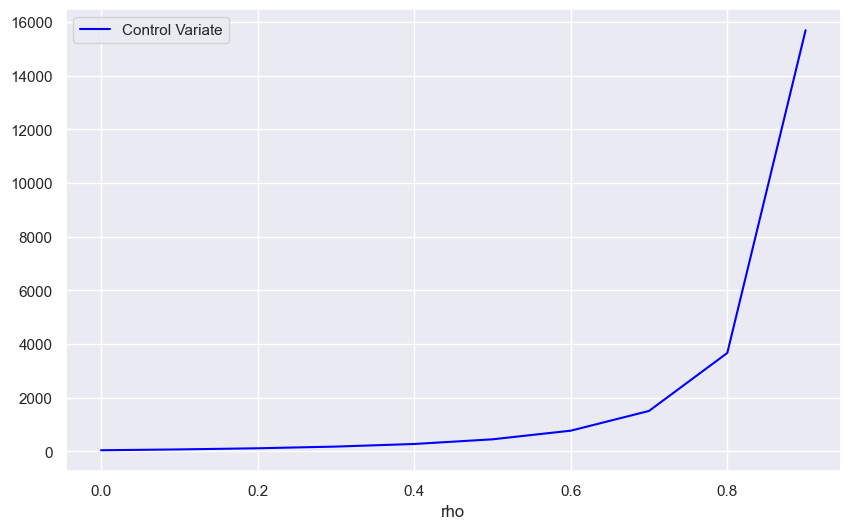

In [145]:
fig = plt.figure(figsize=(10,6))

plt.plot(df_results['rho'], df_results['Ratio_CV'], color='Blue', label='Control Variate')
plt.xlabel('rho')
 #plt.plot(df_results['rho'],df_results['Ratio_Antithetic'])
#plt.xlabel('Time step h')
plt.legend()
plt.show()

Reversly we can see that the more assets are correlated the best the control Variate performs

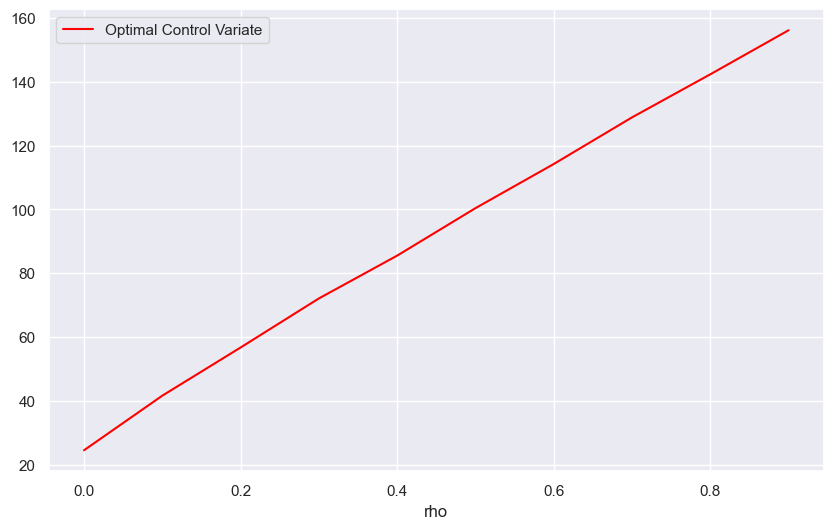

In [146]:
fig = plt.figure(figsize=(10,6))

plt.plot(df_results['rho'], df_results['Ratio_OCV'], color='Red', label='Optimal Control Variate')
plt.xlabel('rho')
 #plt.plot(df_results['rho'],df_results['Ratio_Antithetic'])
#plt.xlabel('Time step h')
plt.legend()
plt.show()

the slope is quite linear with the Optimal Control Variate

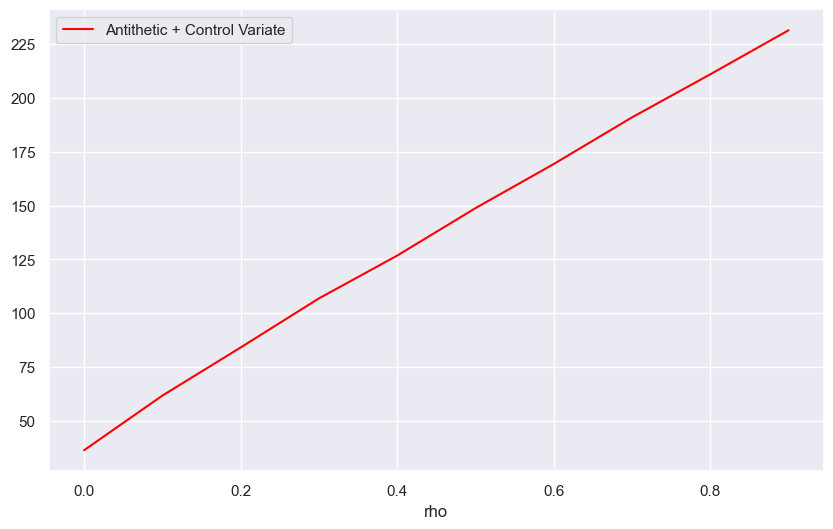

In [148]:
fig = plt.figure(figsize=(10,6))

plt.plot(df_results['rho'], df_results['Ratio_Combi'], color='Red', label='Antithetic + Control Variate')
plt.xlabel('rho')
 #plt.plot(df_results['rho'],df_results['Ratio_Antithetic'])
#plt.xlabel('Time step h')
plt.legend()
plt.show()

the slope is quite linear with the Optimal Control Variate

### 2. Parameter $\sigma$

Let consider that we don't have the same volatility $\sigma$ for all olur assets.

In [204]:
# Fonction de simulation
def run_simulation2(d, rho, sigma_values, T=1, r=0.1, S0_value=100, K=100, n=int(1e5)):
    S0 = np.full(d, S0_value)
    sigma = sigma_values if isinstance(sigma_values, np.ndarray) else np.full(d, sigma_values)
    correl = np.full((d, d), rho) + (1 - rho) * np.eye(d)
    params = {
        "S0": S0[:, np.newaxis],
        "sigma": sigma[:, np.newaxis],
        "mu": r - 0.5 * sigma[:, np.newaxis] ** 2,
        "sq_correl": np.linalg.cholesky(correl),
        "maturity": T,
        "strike": K
    }

    # Générer des variables aléatoires normales
    rng = np.random.default_rng()
    Gn = rng.standard_normal((d, n))

    # Échantillonnage Monte Carlo
    sample = phi(Gn, **params)
    result = monte_carlo(sample)

    # Échantillonnage Antithetic
    sample_antith = phi_antith(Gn, **params)
    result_antith = monte_carlo(sample_antith)

    # Control Variate
    sample_cv = phi(Gn, **params) - psi(Gn, **params)
    result_cv = monte_carlo(sample_cv)

    # Optimal Control Variate
    sample_ocv = sample1(K)  # Assurez-vous que sample1 utilise les bons paramètres
    result_ocv = monte_carlo(sample_ocv)

    # Combinaison de Antithetic et Control Variate
    sample_combi = sample2(K)  # Assurez-vous que sample2 utilise les bons paramètres
    result_combi = monte_carlo(sample_combi)

    return result, result_antith, result_cv, result_ocv, result_combi


In [179]:
# Fonction pour collecter les résultats
def collect_results2(d, rho, sigma_values):
    res, res_antith, res_cv, res_ocv, res_combi = run_simulation(d, rho, sigma_values)

    # Calculer les ratios de variance
    mc_var = res[1]
    antith_var = res_antith[1]
    cv_var = res_cv[1]
    ocv_var = res_ocv[1]
    combi_var = res_combi[1]

    ratio_antith = mc_var / antith_var if antith_var != 0 else None
    ratio_cv = mc_var / cv_var if cv_var != 0 else None
    ratio_ocv = mc_var / ocv_var if ocv_var != 0 else None
    ratio_combi = mc_var / combi_var if combi_var != 0 else None

    results = {
        # Utilisation de la moyenne des sigmas
        "Ratio_Antithetic": ratio_antith,
        "Ratio_CV": ratio_cv,
        "Ratio_OCV": ratio_ocv,
        "Ratio_Combi": ratio_combi
    }

    return pd.DataFrame([results])


In [192]:
# Exemple d'utilisation
d = 40  # Nombre d'actifs
rho = 0.3  # Valeur de la corrélation
sigma_values = np.arange(1, d + 1) / (2 * d)
print(sigma_values)# Exemple de sigma_value

[0.0125 0.025  0.0375 0.05   0.0625 0.075  0.0875 0.1    0.1125 0.125
 0.1375 0.15   0.1625 0.175  0.1875 0.2    0.2125 0.225  0.2375 0.25
 0.2625 0.275  0.2875 0.3    0.3125 0.325  0.3375 0.35   0.3625 0.375
 0.3875 0.4    0.4125 0.425  0.4375 0.45   0.4625 0.475  0.4875 0.5   ]


In [193]:
df_results1 = collect_results2(d, rho, sigma_values)
print(df_results1)


   Ratio_Antithetic   Ratio_CV   Ratio_OCV  Ratio_Combi
0          7.069773  43.940813  102.838521   152.414573


In [196]:
df_melted1=pd.melt(df_results1, var_name='method', value_name='ratio')
df_melted1['method']= df_melted1['method'].str.split('_').str[-1]
df_melted1

,method,ratio
0,Antithetic,7.069773
1,CV,43.940813
2,OCV,102.838521
3,Combi,152.414573


<Axes: xlabel='method', ylabel='ratio'>

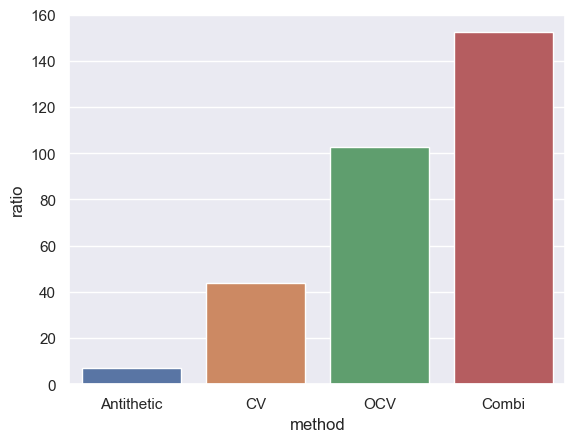

In [197]:
sns.barplot(data=df_melted1, x="method", y="ratio", hue="method")

We can see that if each of our assets has a volatility less then 0.5, the Combination of Antithetic variates and Control variates method and the Optimal Control Variate perform far better than the two other methods 

In [183]:
# Exemple d'utilisation
d = 40  # Nombre d'actifs
rho = 0.3  # Valeur de la corrélation
sigma_values = np.arange(1, d + 1) / (2 * d)
sigma_values_normalized= (sigma_values-np.min(sigma_values))/(np.max(sigma_values)-np.min(sigma_values))
sigma_values_scaled= 0.5 + 0.5*sigma_values_normalized
print(sigma_values_scaled)# Exemple de sigma_value

[0.5        0.51282051 0.52564103 0.53846154 0.55128205 0.56410256
 0.57692308 0.58974359 0.6025641  0.61538462 0.62820513 0.64102564
 0.65384615 0.66666667 0.67948718 0.69230769 0.70512821 0.71794872
 0.73076923 0.74358974 0.75641026 0.76923077 0.78205128 0.79487179
 0.80769231 0.82051282 0.83333333 0.84615385 0.85897436 0.87179487
 0.88461538 0.8974359  0.91025641 0.92307692 0.93589744 0.94871795
 0.96153846 0.97435897 0.98717949 1.        ]


In [184]:
df_results2 = collect_results2(d, rho, sigma_values_scaled)
print(df_results2)


   Ratio_Antithetic  Ratio_CV   Ratio_OCV  Ratio_Combi
0          3.129714  6.217408  831.514979   1232.36895


In [188]:
df_melted=pd.melt(df_results2, var_name='method', value_name='ratio')
df_melted['method']= df_melted['method'].str.split('_').str[-1]
df_melted

,method,ratio
0,Antithetic,3.129714
1,CV,6.217408
2,OCV,831.514979
3,Combi,1232.368950


<Axes: xlabel='method', ylabel='ratio'>

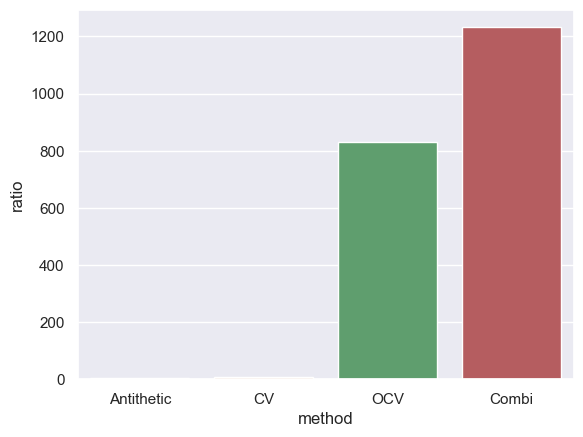

In [191]:
sns.barplot(data=df_melted, x="method", y="ratio", hue="method")

The performance of the antithetic and control variate diminuate while those of optimal control variate and of Combination method raised

### 3. Dependence on the dimension $d$

In [207]:
#N = 500000
rho_values = [0.3]
#print(rho_values)
d_values = [i for i in range(1,100,10)]
sigma_values = [0.2]


In [208]:
def collect_results3(d_values, rho_values, sigma_values):
    results = []
    
    # Étudier la dépendance par rapport à rho
    for d in d_values:
        for sigma in sigma_values:
            for rho in rho_values:
                res, res_antith, res_cv,res_ocv, res_combi = run_simulation(d, rho, sigma)
                #print(res)
                #print(res_antith)
                #print(res_combi)
                
                # Calculer les ratios de variance
                mc_var = res[1]
                antith_var = res_antith[1]
                cv_var = res_cv[1]
                ocv_var= res_ocv[1]
                combi_var=res_combi[1]
                
                ratio_antith =  mc_var/antith_var  if antith_var != 0 else None
                ratio_cv =  mc_var/cv_var if cv_var != 0 else None
                ratio_ocv = mc_var/ocv_var   if ocv_var != 0 else None
                ratio_combi = mc_var/combi_var if combi_var != 0 else None
                
                
                results.append({
                    "d": d,
                    "Ratio_Antithetic": ratio_antith,
                    "Ratio_CV": ratio_cv,
                    "Ratio_OCV": ratio_ocv,
                    "Ratio_Combi": ratio_combi
                    
                })
                
    return pd.DataFrame(results)

In [213]:
df_results4 = collect_results3(d_values=d_values, rho_values=rho_values, sigma_values=sigma_values)

# Display results
df_results4


,d,Ratio_Antithetic,Ratio_CV,Ratio_OCV,Ratio_Combi
0,1,5.412837,1.008708e+32,171.619141,254.352725
1,11,10.532030,1.787657e+02,70.548585,104.558412
2,21,11.440591,2.044136e+02,65.638362,97.281085
3,31,11.868845,2.180271e+02,64.034655,94.904268
4,41,11.982243,2.252420e+02,63.126204,93.557874
5,51,12.175626,2.312431e+02,62.785241,93.052541
6,61,12.370368,2.343431e+02,62.250812,92.260476
7,71,12.515430,2.375406e+02,61.797985,91.589352
8,81,12.244756,2.404823e+02,62.028627,91.931180
9,91,12.570819,2.431818e+02,61.246049,90.771340


### POO

In [41]:
class basket_black_scholes:
    def __init__(self, S0, r, sigma, sq_correl, maturity, strike):
        # initialisation de la propriété S0 
        self.S0 = S0
        # initialisation des autres arguments comme des attributs (sans vérification)
        self.r, self.sigma, self.sq_correl = r, sigma, sq_correl
        self.maturity, self.strike = maturity, strike
    
    @property
    def S0(self):
        return self._S0
    
    @S0.setter
    def S0(self, value):
        if value.any() <= 0:
            raise ValueError('All elements of S0 must be positive. ')
        if len(value.shape) == 2:
            self.dim, c = value.shape 
            if c != 1: 
                raise ValueError('Must be a column vector of shape (d, 1)')
            self._S0 = value
            return 
        if len(value.shape) != 2:
            raise ValueError('Must be a column vector of shape (d, 1)')
        self._S0 = value
    
    def __repr__(self):
        return repr(f"Basket product of strike {self.strike} and maturity {self.maturity} in the BS model.")
        
    def __generate__(self, indep_Gn):
        mu_T = (self.r - 0.5*self.sigma**2) * self.maturity
        sigrho_sqT = self.sigma * np.sqrt(self.maturity) * self.sq_correl
        ST = self.S0 * np.exp(mu_T + sigrho_sqT @ indep_Gn)
        return ST
        
    def call(self, indep_Gn):
        ST = self.__generate__(indep_Gn)
        return np.maximum(np.mean(ST, axis=0) - self.strike, 0)

    def call_cv(self, indep_Gn):
        weight = self.S0 / self.S0.sum()
        m = (weight * (self.r - 0.5*self.sigma**2)).sum() 
        s2 = (((weight * self.sigma).T @ self.sq_correl)**2).sum()
        rho = m + 0.5*s2
        sigrho_sqT = self.sigma * np.sqrt(self.maturity) * self.sq_correl
        Z = np.sum(weight * (m*self.maturity + sigrho_sqT @ indep_Gn), axis = 0)
        
        Y = np.maximum(self.S0.mean() * np.exp(Z) - self.strike, 0) 
        Y_mean = np.exp(rho*T) * price_call_BS(self.S0.mean(), self.maturity, rho, np.sqrt(s2), strike=self.strike) 
        return Y - Y_mean

    def put(self, indep_Gn):
        ST = self.__generate__(indep_Gn)
        return np.maximum(strike - np.mean(ST, axis=0), 0)

    # TODO: def put_cv(self, indep_Gn)

In [42]:
d = 40
S0 = np.full(d, 100)[:, np.newaxis]
r = 0.1
sigma = np.full(d, 0.3)[:, np.newaxis]
rho = 0.3
correl = np.full((d,d), rho) + (1-rho)*np.eye(d) # ou np.diag(np.full(d, 1-0.2))
sq_correl = np.linalg.cholesky(correl)
T = 1
K = 100

X = basket_black_scholes(S0, r, sigma, sq_correl, strike=K, maturity=T)

In [43]:
def compare_numerical_methods(X, size):
    Gn = rng.standard_normal((X.dim, size)) 
    methods = {
        "crude": 
            monte_carlo(X.call(Gn)),
        "antithetic": 
            monte_carlo(0.5*(X.call(Gn) + X.call(-Gn))),
        "control variate": 
            monte_carlo(X.call(Gn) - X.call_cv(Gn)),
        "antithetic + control variate": 
            monte_carlo(0.5*(X.call(Gn) - X.call_cv(Gn)) + 0.5*(X.call(-Gn) - X.call_cv(-Gn))),
    }
    return methods

In [44]:
compare_numerical_methods(X, int(1e6))

{'crude': (13.555861169297609,
  234.33129992848046,
  13.525858268786575,
  13.585864069808643),
 'antithetic': (13.559226523478207,
  36.00338936190468,
  13.54746618599839,
  13.570986860958024),
 'control variate': (13.55508373867327,
  3.4736797095073926,
  13.551430794989013,
  13.558736682357527),
 'antithetic + control variate': (13.55546299396159,
  0.7020475010803481,
  13.553820773950273,
  13.557105213972909)}

In [45]:

class PositiveColumnVector():
    def __set_name__(self, owner, name):
        self.name = name

    def __get__(self, obj, type=None) -> object:
        return obj.__dict__.get(self.name)

    def __set__(self, obj, value) -> None:
        try:
            dim, one = value.shape
        except:
            raise AttributeError(f"{self.name} must be a column vector of shape (d, 1)")
        if one != 1:
            raise AttributeError(f"{self.name} must be a column vector of shape (d, 1)")
        if value.any() <= 0:
            raise AttributeError(f"All elements of {self.name} must be positive.")
        obj.__dict__[self.name] = value

In [46]:
class basket_black_scholes:
    S0 = PositiveColumnVector()
    
    def __init__(self, S0, r, sigma, sq_correl, maturity, strike):
        self.S0 = S0
        self.r, self.sigma, self.sq_correl = r, sigma, sq_correl
        self.maturity, self.strike = maturity, strike
    
    def __repr__(self):
        return repr(f"Basket product of strike {self.strike} and maturity {self.maturity} in the BS model.")
        
    def __generate__(self, indep_Gn):
        mu_T = (self.r - 0.5*self.sigma**2) * self.maturity
        sigrho_sqT = self.sigma * np.sqrt(self.maturity) * self.sq_correl
        ST = self.S0 * np.exp(mu_T + sigrho_sqT @ indep_Gn)
        return ST
        
    def call(self, indep_Gn):
        ST = self.__generate__(indep_Gn)
        return np.maximum(np.mean(ST, axis=0) - self.strike, 0)

In [48]:
S0 = np.full((d, 1), 100)
X = basket_black_scholes(S0, r, sigma, sq_correl, strike=K, maturity=T)
print("Création de X: OK")

S0 = np.full((d,1), 100)
print("Création de Y:")
Y = basket_black_scholes(S0, r, sigma, sq_correl, strike=K, maturity=T)

Création de X: OK
Création de Y:
